In [25]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%cd /home/psimmerl/Documents/work/EasyAI

import os

import numpy as np
from joblib import load
from main import parse_data, feats

import tensorflow as tf
from keras.models import load_model

import ROOT
from ROOT import RDataFrame, TCanvas, TF1, TH1, TLatex, TLine

##############

# USE_EXPERIMENTAL = True
SAVE = True

# GEN_NEVS = 200_000

##############

epoch = 107

mname = 'vae_LD6'

# mname = 'model_small_gBN_dDO5LN'

# feats = [a + b for a in ('e', 'kp', 'km') for b in ('Pt', 'Eta')]
# feats += ['ekpAngle', 'ekmAngle', 'kpkmAngle']

# mname = 'model'
# feats += ['q2']

# mname = 'model_with_phim_mm2'
# feats += ['phim', 'mm2', 'q2']

##############

model_dir = f'models/{mname}'

version = f'ckpt/epoch{epoch}'
if epoch < 1 and 'gan' in mname.lower():
    version = 'GAN'
if epoch < 1 and 'ae' in mname.lower():
    version = 'VAE'

print('\n', mname, version, '\n')

##############

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

ELE_MASS = 0.000510999
PRO_MASS = 0.938272
KAON_MASS = 0.493677

data_dir = 'data/externel'

c = {
  'b' : ROOT.kAzure,
  'g' : ROOT.kGreen + 2,
  'r' : ROOT.kRed + 1,
  'c' : ROOT.kCyan - 3,
  'm' : ROOT.kMagenta + 1,
  'y' : ROOT.kYellow + 1,
  'k' : ROOT.kBlack,
}

##############

ff =  ROOT.TFile(f'{data_dir}/histos.root', 'read')
histos_old = {}
for key_ in ff.GetListOfKeys():
  histos_old[key_.GetTitle()] = key_.ReadObj()#.Clone()
# ff.Close()

##############

model = load_model(f'{model_dir}/{version}')
sclr = load(f'{model_dir}/scaler.joblib')

rdf = RDataFrame('h22', f'{data_dir}/eKpKm_fa2018_sp2019.root')

col_names = list(rdf.GetColumnNames())
if 'kpstat' in col_names:
  rdf = rdf.Filter('kmstat < 4000 && kpstat < 4000')

# feats = [a + b for a in ('e', 'kp', 'km') for b in ('Pt', 'Eta')]
# feats += ['ekpAngle', 'ekmAngle', 'kpkmAngle', 'phim', 'mm2', 'q2']

vals = [*feats]
for v in [*[a+b for a in ('e','kp','km') for b in ('P','Theta','Phi')], 
        'phim', 'mm2', 'q2', 'lambdam', 'xb', 'w', 'y', 't', 'nu']:
  if v not in feats:
    vals.append(v)

print(feats)

rdf = rdf.Define(
    'vals', '''
Double_t eps = 1e-8;
Double_t KAON_MASS = 0.493677, PRO_MASS = 0.938272, ELE_MASS = 0.000510999;
TLorentzVector beam, targ, ele, kp, km;
beam.SetXYZT(0, 0, beamE, beamE);
targ.SetXYZM(0, 0, 0, PRO_MASS);
ele.SetXYZM(ex, ey, ez, ELE_MASS);
kp.SetXYZM(kpx, kpy, kpz, KAON_MASS);
km.SetXYZM(kmx, kmy, kmz, KAON_MASS);

auto eE = ele.E(), eP = ele.P(), eTheta = ele.Theta(), ePhi = ele.Phi();
auto kpE = kp.E(), kpP = kp.P(), kpTheta = kp.Theta(), kpPhi = kp.Phi();
auto kmE = km.E(), kmP = km.P(), kmTheta = km.Theta(), kmPhi = km.Phi();

auto ePt = ele.Pt(), eEta = ele.Eta();
auto kpPt = kp.Pt(), kpEta = kp.Eta();
auto kmPt = km.Pt(), kmEta = km.Eta();

auto ekpAngle = ele.Angle(kp.Vect());
auto ekmAngle = ele.Angle(km.Vect());
auto kpkmAngle = kp.Angle(km.Vect());

auto phim = (kp+km).M(), mm2 = (beam+targ-ele-kp-km).M2();

auto q = beam - ele, eX = beam+targ-ele, pr = beam + targ - ele - kp - km;
auto q2 = -q.M2();
auto xb = q2/(2*targ.M()*q.E());
auto t  = 2*targ.M()*(pr.E()-targ.M());
auto nu = q2/(2*targ.M()*xb);
auto y  = nu/beam.E();
auto w  = eX.M();

auto lambdam = (beam+targ-ele-kp).M();

//phim = TMath::Log(phim - 2*KAON_MASS + eps);
return vector<double>{''' + ','.join(vals) + '};')
for i, v in enumerate(vals):
  rdf = rdf.Define(v, f'vals[{i}]')

print('Evs before MM2 6 sigma cut -',rdf.Count().GetValue())
mm2_mu, mm2_sg = 0.891369, 0.060926
rdf = rdf.Filter(f'{mm2_mu}-6*{mm2_sg} < mm2 && mm2 < {mm2_mu}+6*{mm2_sg}')
print('Evs after MM2 6 sigma cut -',rdf.Count().GetValue())

phi_mu, phi_sg = 1.020039, 0.004812
# rdf = rdf.Filter(f'{phi_mu}-6*{phi_sg} < phim && phim < {phi_mu}+6*{phi_sg}')

# Necessary for MC
rdf = rdf.Filter('1.075 < eEta && eEta < 2.783')
rdf = rdf.Filter('0.300 < kpEta && kpEta < 5.116')
rdf = rdf.Filter('0.437 < kmEta && kmEta < 2.979')

full_data = rdf.AsNumpy()
del full_data['vals']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/psimmerl/Documents/work/EasyAI

 vae_LD6 ckpt/epoch107 

['ePt', 'eEta', 'kpPt', 'kpEta', 'kmPt', 'kmEta', 'ekpAngle', 'ekmAngle', 'kpkmAngle', 'q2', 'xb', 't', 'w']
Evs before MM2 6 sigma cut - 447395
Evs after MM2 6 sigma cut - 142537


In [26]:

NN_data = np.array([full_data[f] for f in feats]).T
NN_data = sclr.transform(NN_data)

logits = np.zeros((len(NN_data), 1), dtype=float)
inference_batch = np.append(np.arange(0, len(NN_data), 1e3, dtype=int), len(NN_data))

for lb, ub in zip(inference_batch[:-1], inference_batch[1:]):
  if model.name == 'generative_adversarial_network':
    logits[lb:ub] = model.discriminator(NN_data[lb:ub])#, model='d')
  elif 'variational_auto_encoder' in model.name:
    out_ = model(NN_data[lb:ub])#, model='d')
    if len(out_) == 4:
      z_mean, z_log_var, z, rec = out_
    else:
      z, rec = out_
    logits[lb:ub] = np.mean((NN_data[lb:ub] - rec)**2, axis=1, keepdims=True)

NN_data = sclr.inverse_transform(NN_data)

full_data['logits'] = logits.astype(float).flatten()

In [37]:

from helpers import Draw, Draw2D, DrawBox, DrawLine, GausFit, gc
nbins = 100

binfo = {
  'ePt'       : ('ePt',       'Electron P_{t};[GeV]'),
  'eEta'      : ('eEta',      'Electron #eta;'),
  'kpPt'      : ('kpPt',      'Kaon^{+} P_{t};'),
  'kpEta'     : ('kpEta',     'Kaon^{+} #eta;'),
  'kmPt'      : ('kmPt',      'Kaon^{-} P_{t};[GeV]'),
  'kmEta'     : ('kmEta',     'Kaon^{-} #eta;'),
  'ekpAngle'  : ('ekpAngle',  'Angle[Electron, Kaon^{+}];[deg]'),
  'ekmAngle'  : ('ekmAngle',  'Angle[Electron, Kaon^{-}];[deg]'),
  'kpkmAngle' : ('kpkmAngle', 'Angle[Kaon^{+}, Kaon^{-}];[deg]'),
  'phim'      : ('phim',      'Invariant K^{+}K^{-} Mass;Mass [GeV]'),
  'mm2'       : ('mm2',       'Missing Mass^{2};Mass^{2} [GeV^{2}]'),
  'q2'        : ('q2',        'Q^{2};Q^{2} [GeV^{2}]'),
  'logits'    : ('logits',    f'{mname} Logits;'),
}

flip_logits = False
idxs = (phi_mu - 2*phi_sg < full_data['phim']) & (full_data['phim'] < phi_mu + 2*phi_sg)
if full_data['logits'][idxs].mean() < full_data['logits'].mean():
  flip_logits = True
  full_data['logits'] *= -1
  print('Flipping Logits')

phi_lgt_ave, phi_lgt_std = full_data['logits'][idxs].mean(), full_data['logits'][idxs].std()

for k in full_data:
  if k in binfo:
    if 'deg' in binfo[k] and np.max(full_data[k]) < np.pi*2*1.05 :
      full_data[k] *= 180 / np.pi
  else:
    binfo[k] = (k, k+';')

  # xmin, xmax = np.min(full_data[k]), np.max(full_data[k])
  xmin, xmax = np.quantile(full_data[k], 0.01), np.quantile(full_data[k], 0.99)
  binfo[k] += (nbins, xmin, xmax)
  full_data[k].astype(float)

rdf = ROOT.RDF.MakeNumpyDataFrame(full_data)

lat = ROOT.TLatex()
sz = 0.04
lat.SetTextSize(sz)
sz *= 1.1


In [38]:
print(f'Logit ave: {phi_lgt_ave:.3f}')
print(f'Logit std: {phi_lgt_std:.3f}')

cut = phi_lgt_ave - 0*phi_lgt_std
print(f'Cutting at: {cut:.2f}\n')

rdf_pass = rdf.Filter(f'logits > {cut}')
rdf_fail = rdf.Filter(f'logits < {cut}')

n_pass = rdf_pass.Count().GetValue()
n_fail = rdf_fail.Count().GetValue()

print(f'Pass - {n_pass:,}')
print(f'Fail - {n_fail:,}')

if SAVE:
  rdf_pass.Snapshot('h22', 'data/processed/eKpKm_NN.root', col_names)

Logit ave: -0.495
Logit std: 0.189
Cutting at: -0.49

Pass - 44,199
Fail - 98,336


In [39]:
n_pass = rdf_pass.Count().GetValue()
n_fail = rdf_fail.Count().GetValue()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file logits.png has been created


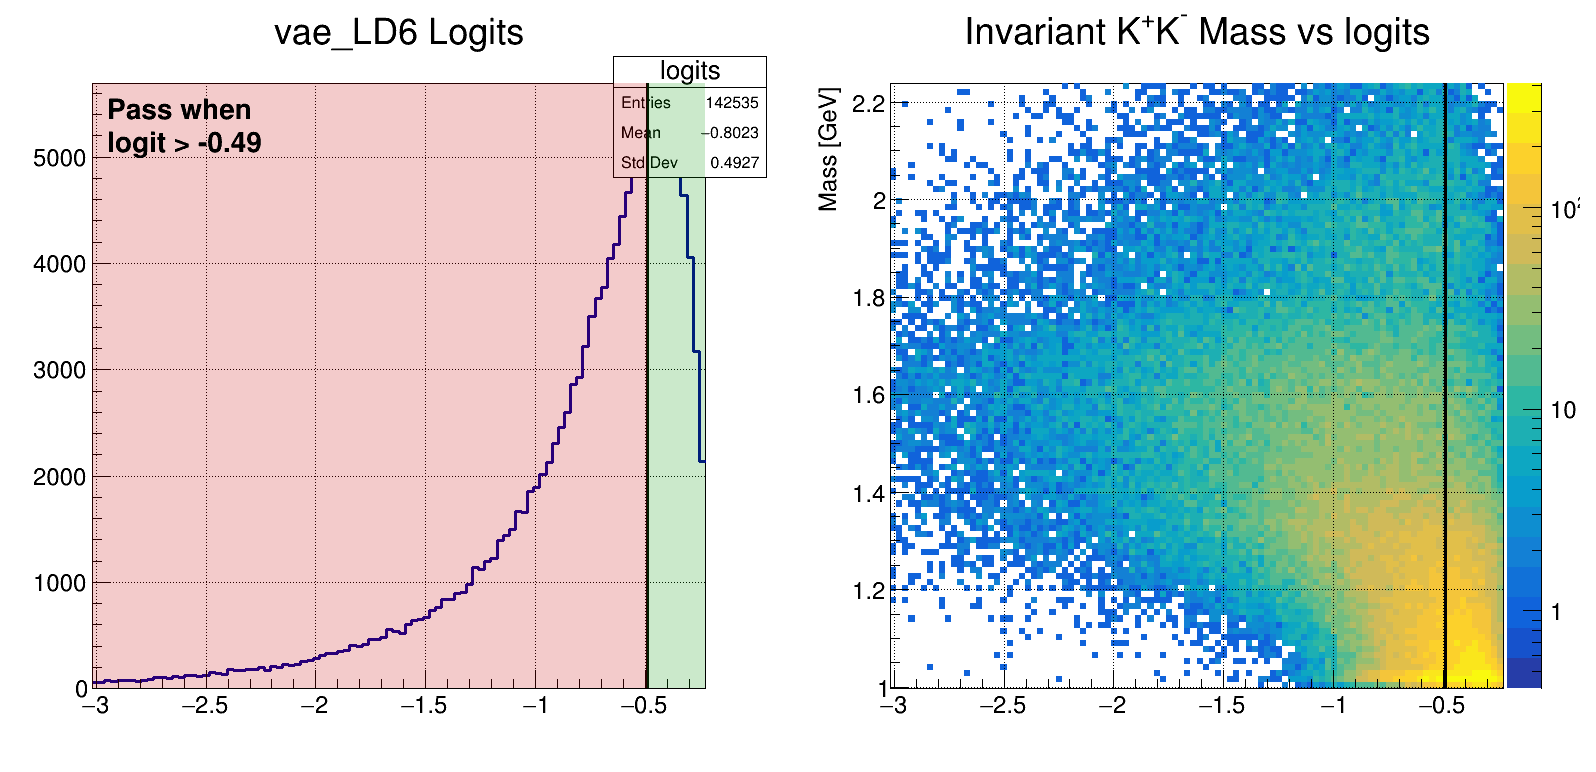

In [40]:
c1 = TCanvas('c1','c1',1600,800); c1.Divide(2,1); c1.Draw()
c1.cd(1).SetGrid()
# c1.cd(1).SetLogy()

hlogits = rdf.Histo1D(binfo['logits'], 'logits')
vmax = hlogits.GetMaximum() * 1.05
hlogits.SetMaximum(vmax)
hlogits.SetLineWidth(3)
hlogits.Draw()

DrawLine(cut,  0, cut,    1, xrange=binfo['logits'][2:])
DrawBox( cut,  0, 100, vmax, xrange=binfo['logits'][2:], color=c['g'])
DrawBox( -200, 0, cut, vmax, xrange=binfo['logits'][2:], color=c['r'])

lat.SetTextAlign(13)
lat.SetTextColor(c['k'])
lat.DrawLatexNDC(0.12, 0.88-0*sz, f"Pass when")
lat.DrawLatexNDC(0.12, 0.88-1*sz, f"logit > {cut:.2f}")

c1.cd(2).SetGrid()
c1.cd(2).SetLogz()

xinfo, yinfo = binfo['logits'], binfo['phim']

xbins = xinfo[-3:]
ybins = yinfo[-3:]
# xbins = (50, lgt_ave-6*lgt_std, xinfo[-1])
# ybins = (50, 0.98, 1.07)

xlab, ylab = xinfo[1].split(';')[1], yinfo[1].split(';')[1]
title = yinfo[1].split(';')[0] +' vs ' + xinfo[0].split(';')[0]
title = title + ';' + xlab +';' + ylab
hlgtphim = rdf.Histo2D(('lgtphim', title, *xbins, *ybins), 'logits', 'phim')
hlgtphim.SetStats(0)
hlgtphim.Draw('colz')

DrawLine(cut, 0, cut, 1, xrange=xbins)
DrawBox(cut, -100, 100, 100, xrange=xbins, color=c['g'])


c1.Print('logits.png')

In [41]:
# c1 = TCanvas('c1','c1',1200,800); c1.Divide(1,1); c1.Draw()
# c1.cd(2).SetGrid()
# c1.cd(2).SetLogz()

# lat.SetTextAlign(13)
# lat.SetTextColor(c['k'])
# lat.DrawLatexNDC(0.12, 0.88-0*sz, f"Pass when")
# lat.DrawLatexNDC(0.12, 0.88-1*sz, f"logit > {cut:.2f}")


# xinfo, yinfo = binfo['logits'], binfo['phim']

# xbins = xinfo[-3:]
# ybins = yinfo[-3:]
# xbins = (50, phi_lgt_ave-6*phi_lgt_std, xinfo[-1])
# ybins = (50, 0.98, 1.15)

# xlab, ylab = xinfo[1].split(';')[1], yinfo[1].split(';')[1]
# title = yinfo[1].split(';')[0] +' vs ' + xinfo[0].split(';')[0]
# title = title + ';' + xlab +';' + ylab
# hlgtphim = rdf.Histo2D(('lgtphim', title, *xbins, *ybins), 'logits', 'phim')
# hlgtphim.SetStats(0)
# hlgtphim.Draw('colz')

# DrawLine(cut, 0, cut, 1, xrange=xbins)
# DrawBox(cut, -100, 100, 100, xrange=xbins, color=c['g'])


# c1.Print('logits.png')

In [42]:
len(feats)

13

4 4 15


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file 1d_feats.png has been created


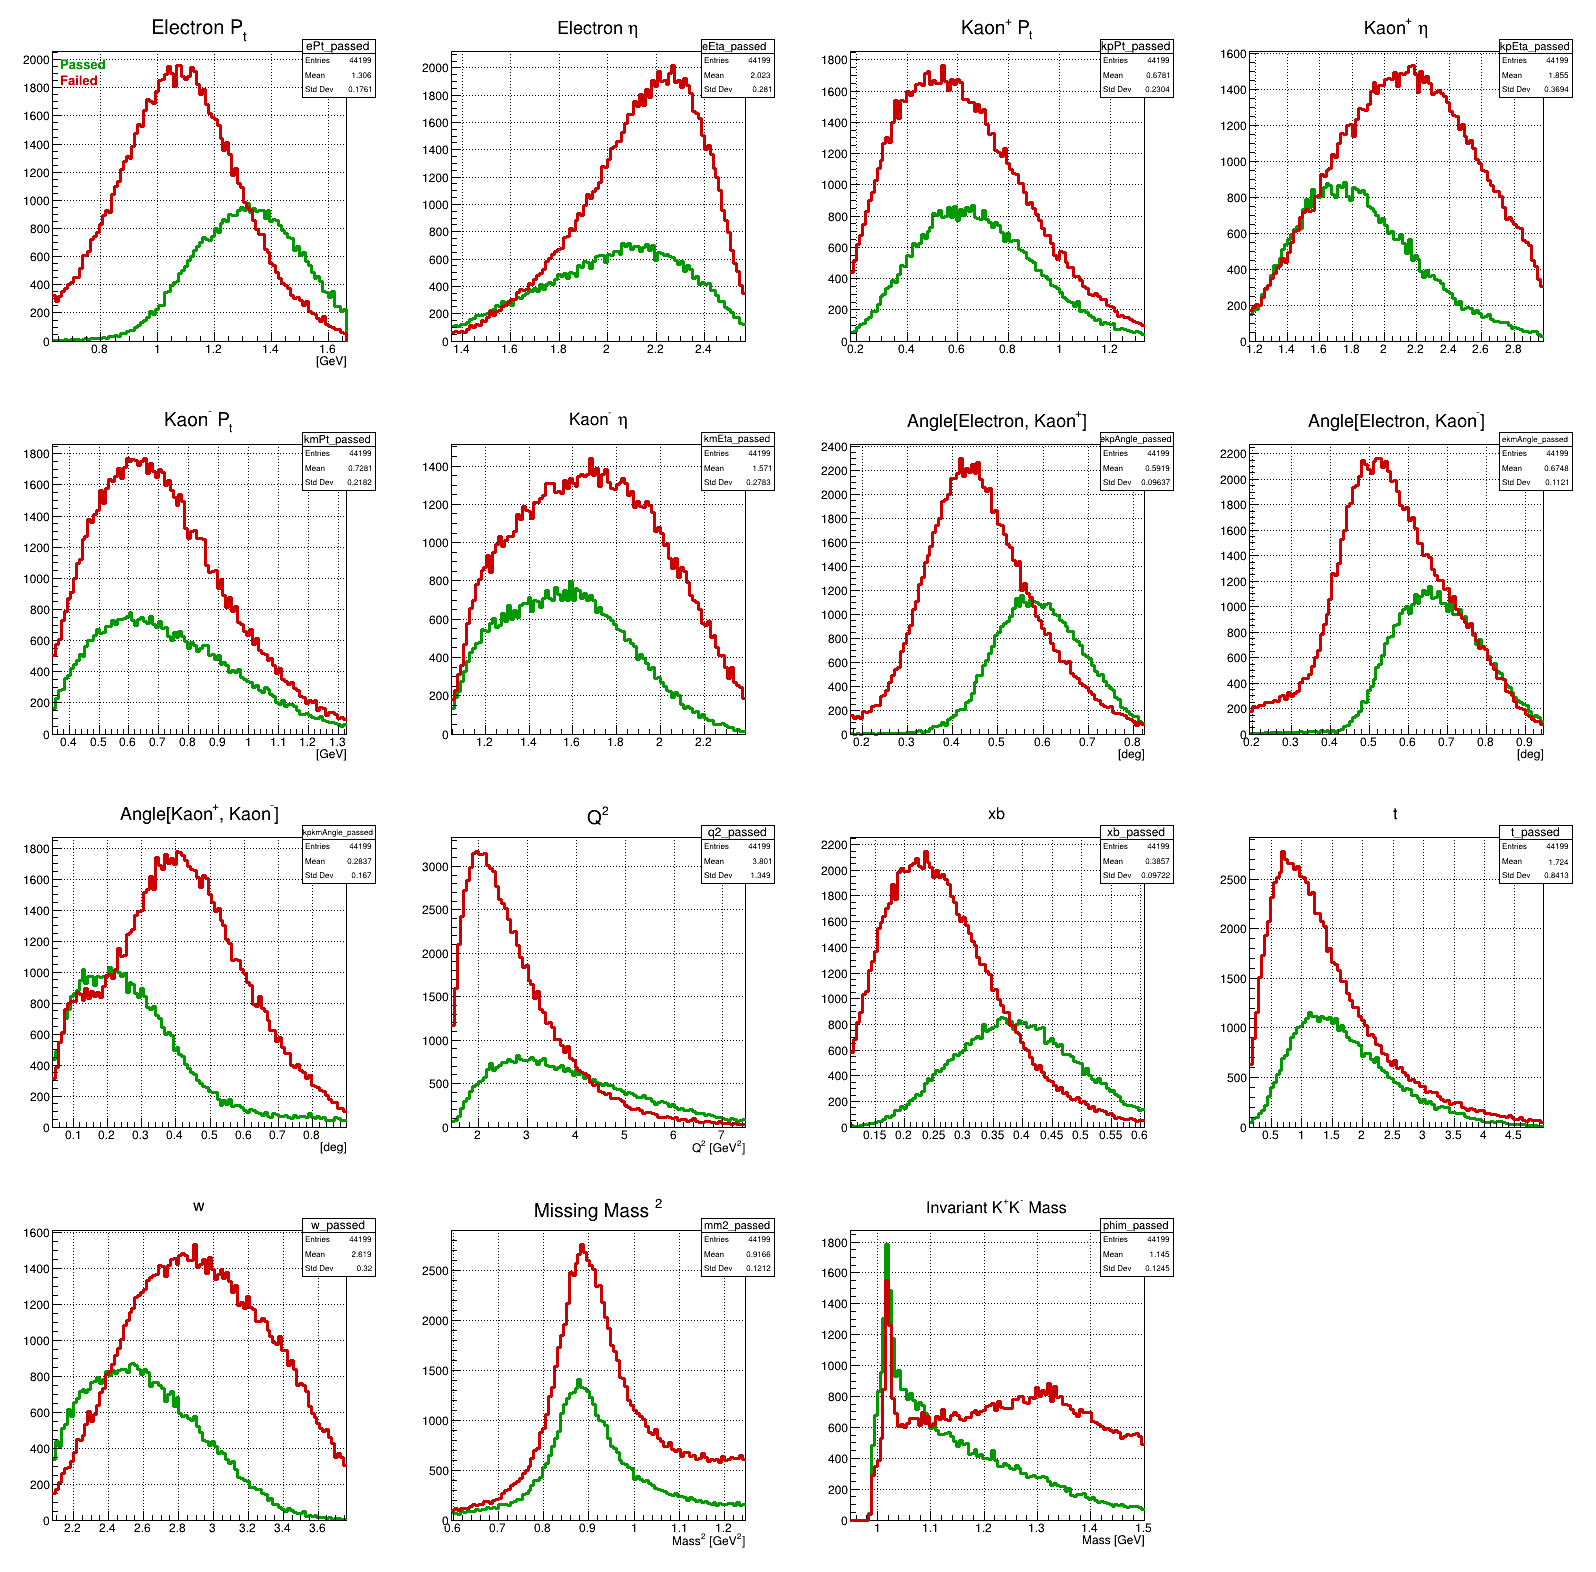

In [43]:
feats2 = [*feats]
for v in ('mm2', 'phim'):
  if v not in feats2:
    feats2.append(v)

rows, cols = np.ceil(np.sqrt(len(feats2))), np.ceil(np.sqrt(len(feats2)))
rows, cols = int(rows), int(cols)
c1 = TCanvas('c1','c1',400*cols,400*rows); c1.Divide(rows,cols); c1.Draw()
print(rows, cols, len(feats2))

for iax, var in enumerate(feats2):
  c1.cd(iax + 1).SetGrid()

  info = binfo[var]

  if var == 'phim':
    info = (info[0], info[1], info[2], 0.95, 1.5)

  hpass = rdf_pass.Histo1D(info, var)
  hfail = rdf_fail.Histo1D(info, var)

  hpass.SetName(var+'_passed')


  vmax = max(hpass.GetMaximum(), hfail.GetMaximum()) * 1.05
  hpass.SetAxisRange(0, vmax, 'y')
  hfail.SetAxisRange(0, vmax, 'y')

  hpass.SetLineColor(c['g'])
  hfail.SetLineColor(c['r'])
  hpass.SetLineWidth(3)
  hfail.SetLineWidth(3)

  hpass.Draw('same')
  hfail.Draw('same')

  gc.extend([hpass, hfail])

c1.cd(1)
lat.SetTextAlign(13)
lat.SetTextColor(c['g'])
lat.DrawLatexNDC(0.12, 0.88-0*sz, f"Passed")
lat.SetTextColor(c['r'])
lat.DrawLatexNDC(0.12, 0.88-1*sz, f"Failed")


c1.Print('1d_feats.png')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file resonances_vs_mm2.png has been created


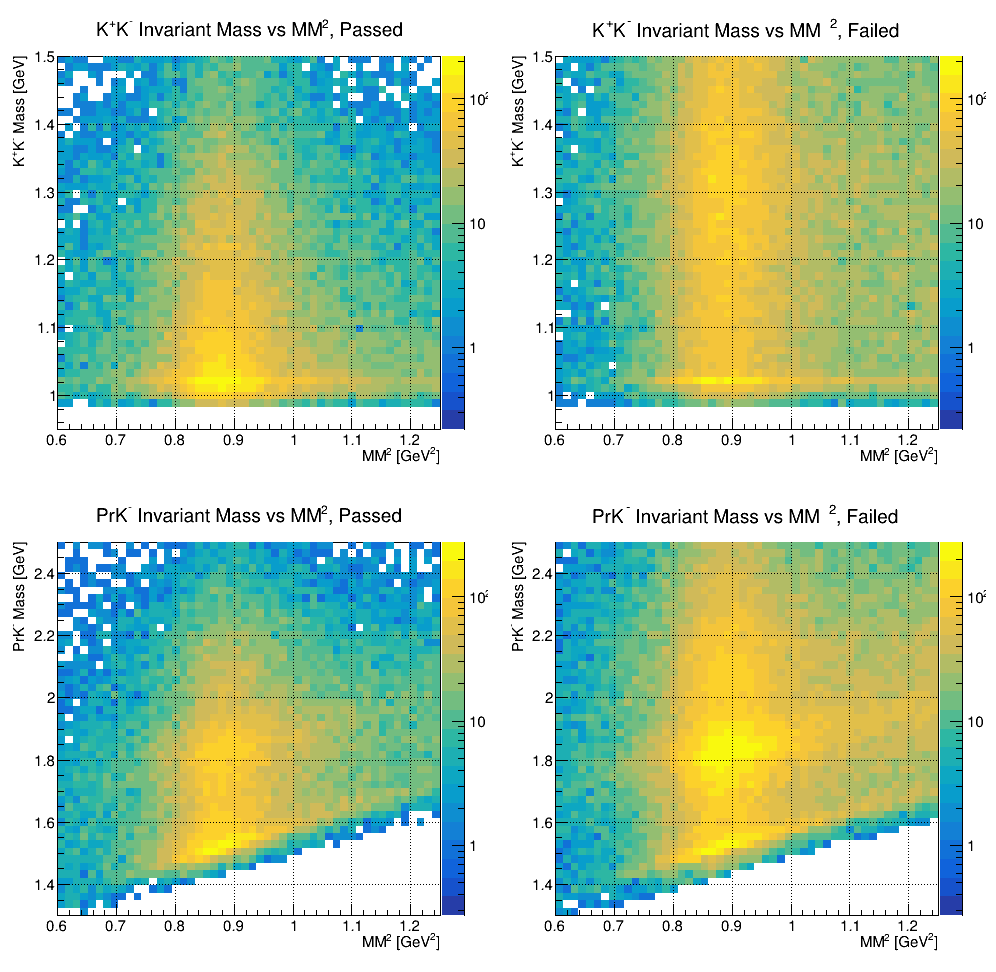

In [44]:
c1 = TCanvas('c1','c1',1000,1000); c1.Divide(2,2); c1.Draw()
logz = True
if logz:
  for i in range(4):
    c1.cd(i+1).SetLogz()

c1.cd(1).SetGrid()

title = 'K^{+}K^{-} Invariant Mass vs MM^{2}'
labs = ';MM^{2} [GeV^{2}];K^{+}K^{-} Mass [GeV]'
bins = (50, 0.6, 1.25, 50, 0.95, 1.5)

hmm2kpkm_pass = rdf_pass.Histo2D(('', title+', Passed'+labs, *bins), 'mm2', 'phim')
hmm2kpkm_fail = rdf_fail.Histo2D(('', title+', Failed'+labs, *bins), 'mm2', 'phim')

vmax = max(hmm2kpkm_pass.GetMaximum(), hmm2kpkm_fail.GetMaximum())
hmm2kpkm_pass.SetMaximum(vmax)
hmm2kpkm_fail.SetMaximum(vmax)

hmm2kpkm_pass.SetStats(0)
hmm2kpkm_fail.SetStats(0)

hmm2kpkm_pass.Draw('col'+('z' if logz else ''))

c1.cd(2).SetGrid()


hmm2kpkm_fail.Draw('col'+('z' if logz else ''))

####

c1.cd(3).SetGrid()

title = 'PrK^{-} Invariant Mass vs MM^{2}'
labs = ';MM^{2} [GeV^{2}];PrK^{-} Mass [GeV]'
bins = (50, 0.6, 1.25, 50, 1.3, 2.5)

hmm2prkm_pass = rdf_pass.Histo2D(('', title+', Passed'+labs, *bins), 'mm2', 'lambdam')
hmm2prkm_fail = rdf_fail.Histo2D(('', title+', Failed'+labs, *bins), 'mm2', 'lambdam')

vmax = max(hmm2prkm_pass.GetMaximum(), hmm2prkm_fail.GetMaximum())
hmm2prkm_pass.SetMaximum(vmax)
hmm2prkm_fail.SetMaximum(vmax)

hmm2prkm_pass.SetStats(0)
hmm2prkm_fail.SetStats(0)

hmm2prkm_pass.Draw('col'+('z' if logz else ''))

c1.cd(4).SetGrid()

hmm2prkm_fail.Draw('col'+('z' if logz else ''))

c1.Print('resonances_vs_mm2.png')

Gain: 1.232 +/- 0.096
S2B gain: 0.740 +/- 0.019
 FCN=153.404 FROM MINOS     STATUS=FAILURE      1749 CALLS        7876 TOTAL
                     EDM=4.40682e-10    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.24842e+00   1.18181e-01   5.16923e-04  -6.73457e-04
   2  p1           1.02007e+00   2.29552e-04  -7.61261e-07   2.58501e+00
   3  p2           1.11268e-02   7.15888e-04   2.16207e-06   4.25370e-01
   4  p3           3.09255e-01   1.40760e-02  -4.61166e-05   7.82344e-02
   5  p4           2.01553e+01   1.46285e-01  -2.47545e-03  -1.90946e-02
   6  p5          -2.07444e+01   1.35684e-01   2.17254e-03  -1.94640e-02
   7  p6           6.10810e+00   1.23021e-01   1.23021e-01  -4.26465e-04
 FCN=124.277 FROM MINOS     STATUS=FAILURE      1625 CALLS        7060 TOTAL
                     EDM=1.20411e-06    STRATEGY= 1      ERR MA

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Error in <TF1Helper::IntegralError>: Last used fitter is not compatible with the current TF1
Error in <TF1Helper::IntegralError>: Last used fitter is not compatible with the current TF1
Error in <TF1Helper::IntegralError>: Last used fitter is not compatible with the current TF1
Info in <TCanvas::Print>: png file phim.png has been created


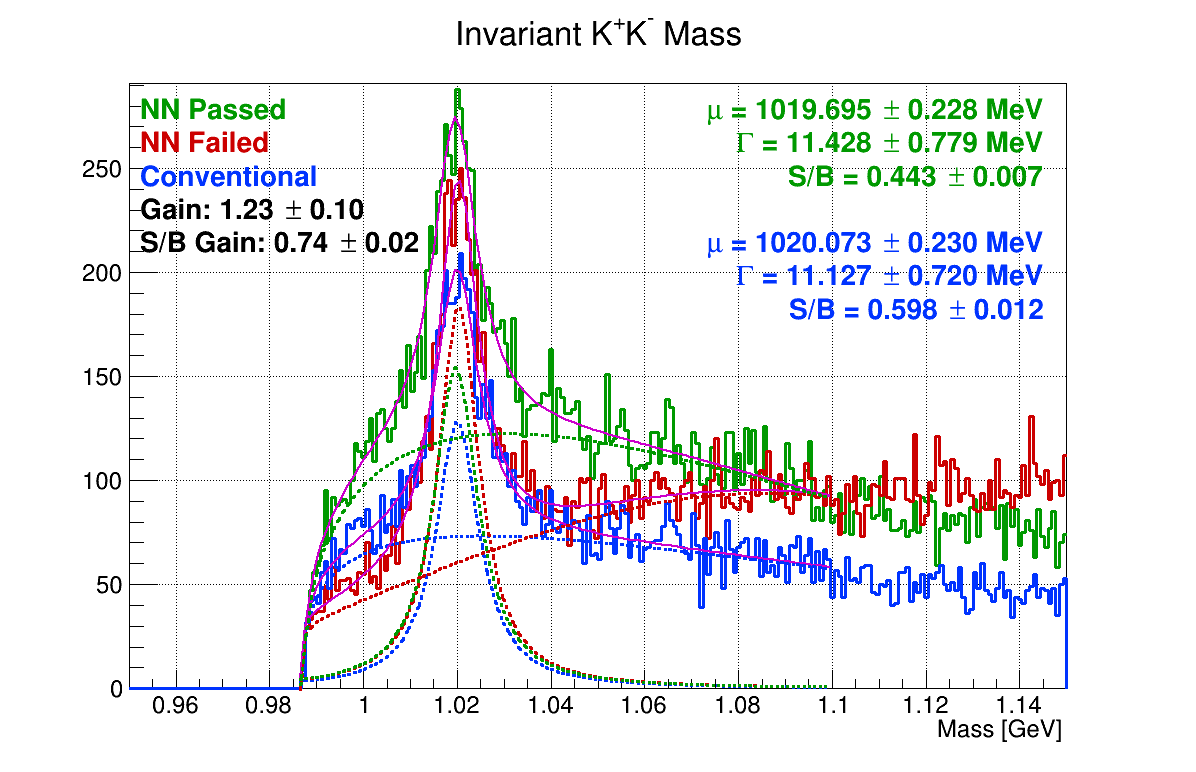

In [45]:
c1 = TCanvas('c1','c1',1200,800); c1.Divide(1,1); c1.Draw()

c1.cd(1).SetGrid()

var = 'phim'
info = binfo[var]
info = (info[0], info[1], 250, 0.95, 1.15)

hpass = rdf_pass.Histo1D(info, var)
hfail = rdf_fail.Histo1D(info, var)
hold = histos_old['im_phi_250_final'].Clone()

vmax = max(hpass.GetMaximum(), hfail.GetMaximum(), hold.GetMaximum()) * 1.01# * 1.01
hpass.SetAxisRange(0, vmax, 'y')
hfail.SetAxisRange(0, vmax, 'y')
hold.SetAxisRange(0, vmax, 'y')

hpass.SetLineColor(c['g'])
hfail.SetLineColor(c['r'])
hold.SetLineColor(c['b'])

hpass.SetLineWidth(3)
hfail.SetLineWidth(3)
hold.SetLineWidth(3)

hpass.SetStats(0)
hfail.SetStats(0)
hold.SetStats(0)

hpass.Draw('same')
hfail.Draw('same')
hold.Draw('same')

bw = 'breitwigner(0)'
bck = f'(x>2*{KAON_MASS})*TMath::Power(abs(x-{2*KAON_MASS}), [3]) * TMath::Exp( [4]+[5]*x+[6]*x*x )'
form = bw+' + '+bck

for hh in (hold, hfail, hpass):
  fmin = hh.GetBinLowEdge(hh.FindFirstBinAbove(0)-1)
  # fmax = min(1.15, hh.GetBinLowEdge(hh.FindLastBinAbove(0)-1))
  fmax = min(1.1, hh.GetBinLowEdge(hh.FindLastBinAbove(0)-1))

  fit = TF1('fform', form, fmin, fmax)
  fit.SetParameters(1, 1.02, 0.01, 0.4059, 9.2857, 0.4835, -3.2580)
  hh.Fit(fit, 'REM')
  pars, errs = fit.GetParameters(), fit.GetParErrors()
  pars = [pars[i] for i in range(7)]
  errs = [errs[i] for i in range(7)]
  fit.SetLineColor(c['m'])
  fit.Draw('same')

  parsNew, errsNew = pars, errs
  if hh is hold:
    parsOld, errsOld = pars, errs

  fitSig = TF1('fform', bw, fmin, fmax)
  fitSig.SetParameters(*pars)
  fitSig.SetParErrors(np.array(errs))
  fitSig.SetLineWidth(3)
  fitSig.SetLineColor(hh.GetLineColor())
  fitSig.SetLineStyle(ROOT.kDashed)
  fitSig.Draw('same')

  fitBck = TF1('fform', bck, fmin, fmax)
  fitBck.SetParameters(*pars)
  fitBck.SetParErrors(np.array(errs))
  fitBck.SetLineWidth(3)
  fitBck.SetLineColor(hh.GetLineColor())
  fitBck.SetLineStyle(ROOT.kDashed)
  fitBck.Draw('same')

  int_min, int_max = pars[1] - 2*pars[2], pars[1] + 2*pars[2]
  int_sig, int_bck = fitSig.Integral(int_min, int_max), fitBck.Integral(int_min, int_max)
  intE_sig, intE_bck = fitSig.IntegralError(int_min, int_max), fitBck.IntegralError(int_min, int_max)
  S2BNew = int_sig /int_bck
  S2BErrNew = np.abs(S2BNew) * np.sqrt( (intE_sig/int_sig)**2 + (intE_bck/int_bck)**2 )
  if hh is hold:
    S2BOld, S2BErrOld = S2BNew, S2BErrNew

  gc.extend([fit, fitSig, fitBck])

gain = parsNew[0] / parsOld[0]
gainE = gain * np.sqrt( (errsNew[0]/parsNew[0])**2 + (errsOld[0]/parsOld[0])**2 )

S2b_gain = S2BNew / S2BOld
S2b_gainE = S2b_gain * np.sqrt( (S2BErrNew/S2BNew)**2 + (S2BErrOld/S2BOld)**2 )
print(f'Gain: {gain:.3f} +/- {gainE:.3f}')
print(f'S2B gain: {S2b_gain:.3f} +/- {S2b_gainE:.3f}')

lat.SetTextAlign(13)
lat.SetTextColor(c['g'])
lat.DrawLatexNDC(0.11, 0.88-0*sz, f"NN Passed")
lat.SetTextColor(c['r'])
lat.DrawLatexNDC(0.11, 0.88-1*sz, f"NN Failed")
lat.SetTextColor(c['b'])
lat.DrawLatexNDC(0.11, 0.88-2*sz, f"Conventional")
lat.SetTextColor(c['k'])
lat.DrawLatexNDC(0.11, 0.88-3*sz, f"Gain: {gain:.2f} #pm {gainE:.2f}")
lat.DrawLatexNDC(0.11, 0.88-4*sz, f"S/B Gain: {S2b_gain:.2f} #pm {S2b_gainE:.2f}")

lat.SetTextAlign(33)
lat.SetTextColor(c['g'])
lat.DrawLatexNDC(0.88, 0.88-0*sz, f"#mu = {parsNew[1]*1000:.3f} #pm {errsNew[1]*1000:.3f} MeV")
lat.DrawLatexNDC(0.88, 0.88-1*sz, f"#Gamma = {parsNew[2]*1000:.3f} #pm {errsNew[2]*1000:.3f} MeV")
lat.DrawLatexNDC(0.88, 0.88-2*sz, f"S/B = {S2BNew:.3f} #pm {S2BErrNew:.3f}")
lat.SetTextColor(c['b'])
lat.DrawLatexNDC(0.88, 0.88-4*sz, f"#mu = {parsOld[1]*1000:.3f} #pm {errsOld[1]*1000:.3f} MeV")
lat.DrawLatexNDC(0.88, 0.88-5*sz, f"#Gamma = {parsOld[2]*1000:.3f} #pm {errsOld[2]*1000:.3f} MeV")
lat.DrawLatexNDC(0.88, 0.88-6*sz, f"S/B = {S2BOld:.3f} #pm {S2BErrOld:.3f}")



c1.Print('phim.png')

Gain: 1.217


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file mm2.png has been created


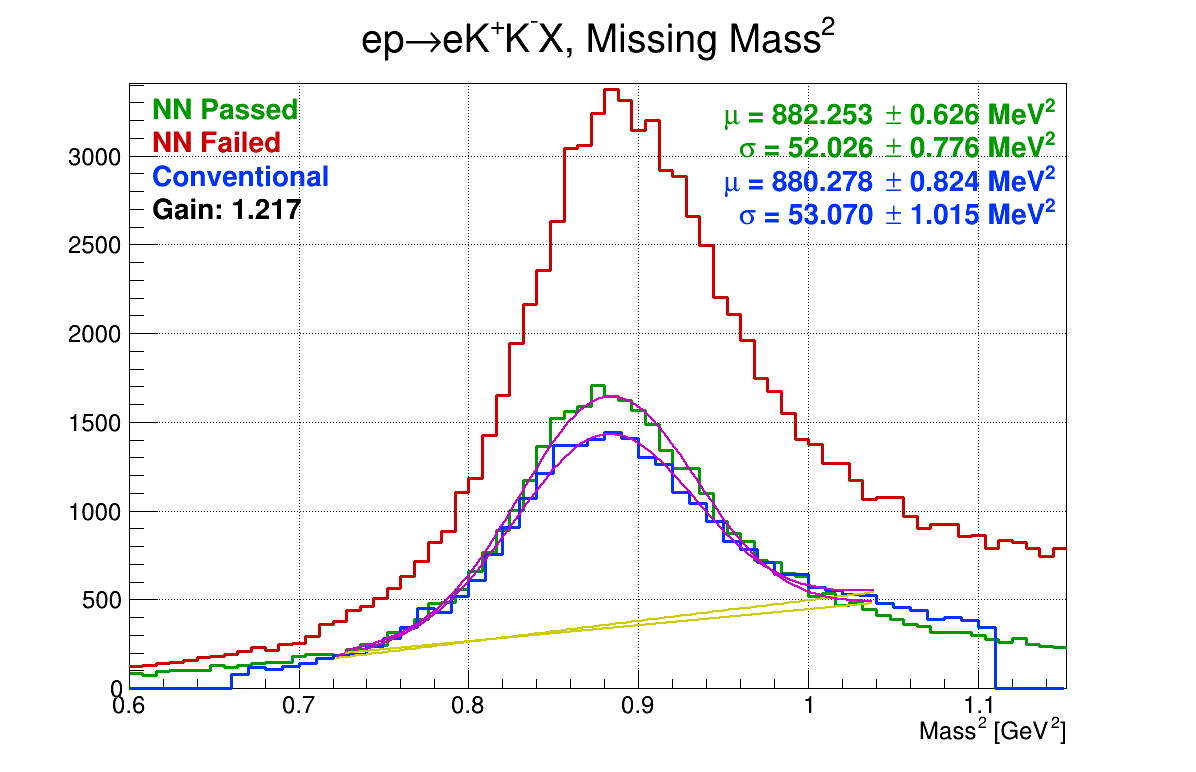

In [46]:
c1 = TCanvas('c1','c1',1200,800); c1.Divide(1,1); c1.Draw()

c1.cd(1).SetGrid()

var = 'mm2'
info = binfo[var]
info = (info[0], 'ep#rightarroweK^{+}K^{-}X, '+info[1], 250, 0.0, 2)

hpass = rdf_pass.Histo1D(info, var)
hfail = rdf_fail.Histo1D(info, var)
hold = histos_old['mm2_ekpkmX_final'].Clone()

hpass.SetAxisRange(0.6, 1.15, 'x')
hfail.SetAxisRange(0.6, 1.15, 'x')
hold.SetAxisRange(0.6, 1.15, 'x')

vmax = max(hpass.GetMaximum(), hfail.GetMaximum(), hold.GetMaximum()) * 1.01# * 1.01
# vmax = max(hpass.GetMaximum(), hold.GetMaximum()) * 1.01
hpass.SetAxisRange(0, vmax, 'y')
hfail.SetAxisRange(0, vmax, 'y')
hold.SetAxisRange(0, vmax, 'y')

hpass.SetLineColor(c['g'])
hfail.SetLineColor(c['r'])
hold.SetLineColor(c['b'])

hpass.SetLineWidth(3)
hfail.SetLineWidth(3)
hold.SetLineWidth(3)

hpass.SetStats(0)
hfail.SetStats(0)
hold.SetStats(0)

hpass.Draw('same')
hfail.Draw('same')
hold.Draw('same')

for hh in (hold, hpass):
  fits, pars, errs = GausFit(hh, [1000, PRO_MASS**2, 0.05], 1, lw=2, draw=False)
  fits[0].SetLineColor(c['m'])
  fits[0].Draw('same')
  fits[2].SetLineColor(c['y'])
  fits[2].Draw('same')
#   fmin = hh.GetBinLowEdge(hh.FindFirstBinAbove(0)-1)
#   fit = TF1('fform', form, fmin, 1.1)
#   fit.SetParameters(10, 1.02, 0.01, 0.4059, 9.2857, 0.4835, -3.2580)
#   hh.Fit(fit, 'REM')
#   pars, errs = fit.GetParameters(), fit.GetParErrors()
#   pars = [pars[i] for i in range(7)]
#   errs = [errs[i] for i in range(7)]
#   fit.SetLineColor(c['m'])
#   fit.Draw('same')

  parsNew, errsNew = pars, errs
  if hh is hold:
    parsOld, errsOld = pars, errs

print(f'Gain: {parsNew[0] / parsOld[0]:.3f}')

lat.SetTextAlign(13)
lat.SetTextColor(c['g'])
lat.DrawLatexNDC(0.12, 0.88-0*sz, f"NN Passed")
lat.SetTextColor(c['r'])
lat.DrawLatexNDC(0.12, 0.88-1*sz, f"NN Failed")
lat.SetTextColor(c['b'])
lat.DrawLatexNDC(0.12, 0.88-2*sz, f"Conventional")
lat.SetTextColor(c['k'])
lat.DrawLatexNDC(0.12, 0.88-3*sz, f"Gain: {parsNew[0] / parsOld[0]:.3f}")

lat.SetTextAlign(33)
lat.SetTextColor(c['g'])
lat.DrawLatexNDC(0.89, 0.88-0*sz, f"#mu = {parsNew[1]*1000:.3f} #pm {errsNew[1]*1000:.3f} MeV^{{2}}")
lat.DrawLatexNDC(0.89, 0.88-1*sz, f"#sigma = {parsNew[2]*1000:.3f} #pm {errsNew[2]*1000:.3f} MeV^{{2}}")
lat.SetTextColor(c['b'])
lat.DrawLatexNDC(0.89, 0.88-2*sz, f"#mu = {parsOld[1]*1000:.3f} #pm {errsOld[1]*1000:.3f} MeV^{{2}}")
lat.DrawLatexNDC(0.89, 0.88-3*sz, f"#sigma = {parsOld[2]*1000:.3f} #pm {errsOld[2]*1000:.3f} MeV^{{2}}")

c1.Print('mm2.png')